In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import keras.backend as K
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
import os
from glob import glob
import ntpath
import cv2
from tqdm import tqdm_notebook as tqdm_notebook
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

##### Set Constant #####
path_root = '/data/examples/may_the_4_be_with_u/where_am_i/'

Using TensorFlow backend.


In [13]:
path = '/data/examples/may_the_4_be_with_u/where_am_i/train'
data_path_list = [path]

img_rows=200
img_cols=200
num_channel=1

# Define number of classes
num_classes = 15

img_data_list=[]
for data_path in data_path_list:
    for dataset in sorted(os.listdir(data_path), key=str.lower): 
        #dataset = ['bedroom', 'CALsuburb', 'coast', 'forest', 'highway', 'industrial', 'insidecity', 'kitchen',
        # 'livingroom', 'mountain', 'opencountry', 'PARoffice', 'store', 'street', 'tallbuilding']
        img_list = os.listdir(data_path+'/'+ dataset)
        print('Loaded the images of dataset-' +  '%s/%s\n' % (data_path, dataset))
        for img in img_list:
            if img.endswith('.jpg'):
                input_img = cv2.imread(data_path + '/'+ dataset + '/'+ img)
                input_img_resize=cv2.resize(input_img,(256,256)) # 你要resize成為多少，我預設128
                #kernel_sharpening = np.array([[-1,-1,-1], 
                #                              [-1, 9,-1],
                #                              [-1,-1,-1]])
                #input_sharpened = cv2.filter2D(input_img_resize, -1, kernel_sharpening)
                #cv2.resize(cv2.imread(X_list[i]),(128,128),
                #       interpolation=cv2.INTER_CUBIC)[np.newaxis,:]    
                img_data_list.append(input_img_resize)
    
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/bedroom

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/CALsuburb

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/coast

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/forest

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/highway

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/industrial

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/insidecity

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/kitchen

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/livingroom

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/mountain

Loaded the images of dataset-/data/examples/may_the_4_be_with_u/where_am_i/train/opencountr

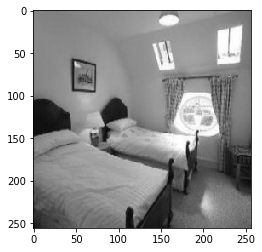

In [3]:
plt.imshow(img_data[1][:,:])
plt.show()

In [4]:
for data_path in data_path_list:
    for dataset in sorted(os.listdir(data_path), key=str.lower): 
        img_list = os.listdir(data_path+'/'+ dataset)
        print(dataset,'There are',len(img_list),'images')

bedroom There are 116 images
CALsuburb There are 141 images
coast There are 260 images
forest There are 228 images
highway There are 160 images
industrial There are 211 images
insidecity There are 208 images
kitchen There are 110 images
livingroom There are 189 images
mountain There are 274 images
opencountry There are 310 images
PARoffice There are 115 images
store There are 215 images
street There are 192 images
tallbuilding There are 256 images


In [5]:
# classes: from mid_term_mapping.txt
image_classes = ['kitchen', 
                 'street', 
                 'industrial',
                 'insidecity',
                 'forest',
                 'livingroom',
                 'opencountry',
                 'PARoffice', 
                 'mountain', 
                 'CALsuburb', 
                 'coast', 
                 'store', 
                 'bedroom', 
                 'tallbuilding', 
                 'highway']

In [6]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64') # 一熱

index = 0
label = 0
for data_path in data_path_list:
    for dataset in sorted(os.listdir(data_path), key=str.lower):
        
        img_list = os.listdir(data_path+'/'+ dataset)
        this_class = image_classes.index(dataset)
        print(this_class)
        labels[index: index+len(img_list)] = this_class
        label+=1
        index+=len(img_list)

12
9
10
4
14
2
3
0
5
8
6
7
11
1
13


In [7]:
img_data = img_data.reshape(-1, 256, 256, 3) # 128是resize時候自己設定的
print('image_data',img_data.shape)

# One-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

# Shuffle the data
from sklearn.utils import shuffle
x,y = shuffle(img_data,Y, random_state=2)
# Split the data into training set and validation set
print('x shape',x.shape)
print('y shape', y.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=2)

image_data (2985, 256, 256, 3)
x shape (2985, 256, 256, 3)
y shape (2985, 15)


### Simple DNN

In [8]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      73792     
__________

In [11]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(X_train)

In [ ]:
#training
batch_size = 64
epochs=50

# initiate optimizer
opt = keras.optimizers.Adam()

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    workers=4,
                    callbacks=[earlystop])
#model.save_weights('cifar10_normal_rms_ep125.h5')

#testing - no kaggle eval
scores = model.evaluate(X_test, Y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

In [ ]:
# Score trained model.
scores = dense_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [14]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [15]:
# Test Set List
test_path = '/data/examples/may_the_4_be_with_u/where_am_i/testset'
test_list = glob(os.path.join(test_path, "*.jpg"))
test_id = [path_leaf(s).strip('.jpg') for s in test_list]

In [16]:
test_data_list =[]

for i in range(len(test_list)):
    input_img = cv2.imread(test_list[i])
    input_img_resize=cv2.resize(input_img,(256,256)) # 你要resize成為多少，我預設128
    #kernel_sharpening = np.array([[-0.5,-0.5,-0.5], 
    #                            [-0.5, 4.5,-0.5],
    #                            [-0.5,-0.5,-0.5]])
    #input_sharpened = cv2.filter2D(input_img_resize, -1, kernel_sharpening)
    test_data_list.append(input_img_resize)
    
test_data = np.array(test_data_list)    
test_data = test_data.astype('float32')
test_data /= 255
print(test_data.shape)

(1500, 256, 256, 3)


In [37]:
print(test_data.shape)
#test_data_c = np.expand_dims(test_data, 3)
#test_data_c.shape

(1500, 256, 256, 3)


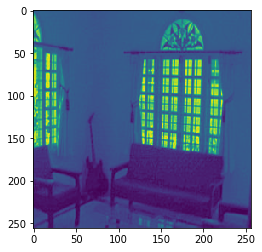

In [38]:
plt.imshow(test_data[0][:,:,0])
plt.show()

In [ ]:
len(test_data)

In [28]:
#Predition
y_pred = inc_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

In [23]:
y_pred

array([12,  3,  3, ...,  7,  6,  8])

In [29]:
df = pd.DataFrame( {"Id": test_id, "class": pd.Series(y_pred)} )
df = df[['Id', 'class']]

In [30]:
df.head(20)

,Id,class
0,7dc74b51e229d841272c0795cffed857d0e6038a4be0c9...,12
1,1b1940d44fe4f5b76e89f876de3d2514a51b50057cae3e...,3
2,7cb3479dac3e7dcc69241f4cd957380a48399b1aa0480d...,3
3,dbbcb75061f5a6ac493af0fa87ce806977a0a4cebce9b7...,1
4,d3238e3700b076099b4fad94dc1714d2bf14c7aedb2e24...,13
5,a21cc1e697ded6db433fd1da001987a355c31b71c7e961...,11
6,6a73b085d9ccfab6d3654a28b81e364861227a69e6a203...,0
7,937035ed06d0df149906f6027ada39407547defff95d27...,7
8,79d8910424501abea0670c9b5ffbcf8d18e614fc9af3ab...,8
9,0815d5dc7e07e70a5758398c577cc110a33563412a251f...,0


In [26]:
df.to_csv('submission.csv', index = False)

### Inception V3

In [39]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

batch_size = 128
epochs=500
opt = keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
inc_model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
inc_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# train the model on the new data for a few epochs
inc_model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    workers=4,
                    callbacks=[earlystop])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in inc_model.layers[:249]:
   layer.trainable = False
for layer in inc_model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
inc_model.compile(optimizer=opt, loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_history = inc_model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    workers=4,
                    callbacks=[earlystop])

Epoch 1/500
18/18 [==============================] - 11s 596ms/step - loss: 2.8777 - acc: 0.0517 - val_loss: 3.0562 - val_acc: 0.0361
Epoch 2/500
18/18 [==============================] - 7s 396ms/step - loss: 2.8653 - acc: 0.0561 - val_loss: 3.0315 - val_acc: 0.0361
Epoch 3/500
18/18 [==============================] - 7s 390ms/step - loss: 2.8491 - acc: 0.0570 - val_loss: 3.0025 - val_acc: 0.0361
Epoch 4/500
18/18 [==============================] - 7s 394ms/step - loss: 2.8326 - acc: 0.0630 - val_loss: 2.9721 - val_acc: 0.0308
Epoch 5/500
18/18 [==============================] - 7s 393ms/step - loss: 2.8082 - acc: 0.0687 - val_loss: 2.9408 - val_acc: 0.0321
Epoch 6/500
18/18 [==============================] - 7s 398ms/step - loss: 2.7975 - acc: 0.0722 - val_loss: 2.9111 - val_acc: 0.0335
Epoch 7/500
18/18 [==============================] - 7s 401ms/step - loss: 2.7741 - acc: 0.0796 - val_loss: 2.8829 - val_acc: 0.0348
Epoch 8/500
18/18 [==============================] - 7s 395ms/step -

In [27]:
# Score trained model.
scores = inc_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores)
#print('Test accuracy:', scores[1])

747/747 [==============================] - 2s 3ms/step
Test loss: 0.39014211295
